In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import os


In [50]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.4)(p)
        
    return f, p

def upsample_block(x, f, n_base, batch_normalization, dropout):
    
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    x = Concatenate()([x,f])
    if(dropout):
        x = layers.Dropout(0.4)(x)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [51]:
def get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):
    
#     ## Parameters
#     n_base = 8
#     LR = 1e-4
#     batch_normalization = True
#     dropout = False
    
    
    ## Encoder part
#     model = Sequential()
    inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p1 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p2 = downsample_block(p1, n_base*2, batch_normalization, dropout)
    f3, p3 = downsample_block(p2, n_base*4, batch_normalization, dropout)
    f4, p4 = downsample_block(p3, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p4, n_base*16, batch_normalization)
    
    ## Decoder part
    p5 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout)
    p6 = upsample_block(p5, f3, n_base*4, batch_normalization, dropout)
    p7 = upsample_block(p6, f2, n_base*2, batch_normalization, dropout)
    p8 = upsample_block(p7, f1, n_base, batch_normalization, dropout)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
#     model = model(inputs = inputs, outputs = outputs)
    model.summary()
    
    return model


In [52]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [53]:
## Task1a) Lung segmentation in chest X-ray images:
from random import shuffle
from skimage.io import imread
from skimage.transform import resize

n_base =16
LR = 1e-4
batch_normalization = True
dropout = True
epochs = 50
batch_size = 16

img_w, img_h = 240,240
img_ch = 1

model = get_unet(img_w, img_h, img_ch, n_base, LR, 
                 batch_normalization, dropout)

## BCE Parameters
# model.compile(loss = 'binary_crossentropy',          # Model Compiling   
#               optimizer = Adam(lr = LR),
#               metrics = ['binary_accuracy'])


## Dice Parameters
model.compile(loss = [dice_coef_loss],          # Model Compiling   
              optimizer = Adam(lr = LR),
              metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 240, 240, 16  160         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 240, 240, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

In [54]:
## Get paths for images and masks
datapath = '/DL_course_data/Lab3/MRI/' 
image_path = '/DL_course_data/Lab3/MRI/Image'
mask_path = '/DL_course_data/Lab3/MRI/Mask'

image_path_list = os.listdir(image_path)
mask_path_list = os.listdir(mask_path)

In [55]:
## Try out with flow from dataframe
image_list = [os.path.join(image_path,i) for i in image_path_list]
mask_list = [ i.replace(".png","_Tumor.png") for i in image_list]
data = pd.DataFrame()
data['images'] = image_list
data['masks'] = mask_list


## Generator
data_gen_args = dict(rescale=1/255.,validation_split=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
train_image_generator = image_datagen.flow_from_directory(
    datapath,
    classes=['Image'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size=(240,240),
    batch_size = batch_size,
    subset = 'training',
    seed=seed)

train_mask_generator = mask_datagen.flow_from_directory(
    datapath,
    classes=['Mask'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size=(240,240),
    batch_size = batch_size,
    subset = 'training',
    seed=seed)

val_image_generator = image_datagen.flow_from_directory(
    datapath,
    classes=['Image'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size=(240,240),
    batch_size = batch_size,
    subset = 'validation',
    seed=seed)
val_mask_generator = mask_datagen.flow_from_directory(
    datapath,
    classes=['Mask'],
    class_mode=None,
    color_mode = 'grayscale',
    target_size=(240,240),
    batch_size = batch_size,
    subset = 'validation',
    seed=seed)
# combine generators into one which yields image and masks


def combine_generator(gen1, gen2):
    while True:
        x = gen1.next()
        y = gen2.next()
        yield(x, y)

train_generator = combine_generator(train_image_generator, train_mask_generator)
val_generator = combine_generator(val_image_generator, val_mask_generator)

train_steps = train_image_generator.n//train_image_generator.batch_size
val_steps = val_image_generator.n//val_image_generator.batch_size

model_histogram = model.fit_generator(train_generator, 
    steps_per_epoch = train_steps,
    validation_data = val_generator, validation_steps = val_steps,
    epochs = epochs, verbose=1)


Found 7523 images belonging to 1 classes.
Found 7523 images belonging to 1 classes.
Found 1880 images belonging to 1 classes.
Found 1880 images belonging to 1 classes.
Epoch 1/50


<ipython-input-55-9ef1103b2cb2>:69: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_histogram = model.fit_generator(train_generator,


470/470 [==============================] - 75s 154ms/step - loss: 0.9236 - dice_coef: 0.0764 - precision_1: 0.0701 - recall_1: 0.9577 - val_loss: 0.9426 - val_dice_coef: 0.0574 - val_precision_1: 0.2619 - val_recall_1: 0.5314
Epoch 2/50
470/470 [==============================] - 72s 154ms/step - loss: 0.8844 - dice_coef: 0.1155 - precision_1: 0.2986 - recall_1: 0.9255 - val_loss: 0.8845 - val_dice_coef: 0.1155 - val_precision_1: 0.2091 - val_recall_1: 0.8919
Epoch 3/50
470/470 [==============================] - 73s 155ms/step - loss: 0.8453 - dice_coef: 0.1547 - precision_1: 0.4253 - recall_1: 0.9308 - val_loss: 0.8513 - val_dice_coef: 0.1487 - val_precision_1: 0.3362 - val_recall_1: 0.8731
Epoch 4/50
470/470 [==============================] - 73s 155ms/step - loss: 0.7405 - dice_coef: 0.2594 - precision_1: 0.5664 - recall_1: 0.9150 - val_loss: 0.7112 - val_dice_coef: 0.2888 - val_precision_1: 0.5506 - val_recall_1: 0.8306
Epoch 5/50
470/470 [==============================] - 73s 155ms

In [8]:
def load_data(image_path,mask_path, img_h, img_w, p):
    
    images = []
    masks = []

    for image in image_list:
        img = imread(image, as_gray=True)  # "as_grey"
        img = resize(img, (img_h, img_w), anti_aliasing=True).astype('float32')
        images.append(img)

    for mask in mask_list:
        mask_img = imread(mask, as_gray=True)
        mask = resize(mask_img, (img_h, img_w), anti_aliasing=True).astype('float32')
        masks.append(mask)

    ## Load data in traditional way
    img_train, img_val, mask_train, mask_val = train_test_split(images, masks, shuffle = True,
                                                      test_size = p)
    img_train = np.expand_dims(img_train, axis = -1)
    img_train = np.array(img_train)
    img_val = np.expand_dims(img_val, axis = -1)    
    img_val = np.array(img_val)
    mask_train = np.expand_dims(mask_train, axis = -1)
    mask_train = np.array(mask_train)
    mask_val = np.expand_dims(mask_val, axis = -1)
    mask_val = np.array(mask_val)
    
    return img_train, img_val, mask_train, mask_val

In [9]:
image_list = [os.path.join(image_path,i) for i in image_path_list]
mask_list = [ os.path.join(mask_path,i.replace(".png","_Tumor.png")) for i in image_path_list]
img_train, img_val, mask_train, mask_val = load_data(image_list,mask_list, 240, 240, 0.2)

In [ ]:
image = imread('/DL_course_data/Lab3/CT/Image/Im68_54.png')
mask = imread('/DL_course_data/Lab3/CT/Mask/Im68_54.png')

row, col = image.shape
def show_paired(pic_1, pic_2):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(pic_1, cmap='gray')
    ax[0].set_title("Brain image")
    ax[1].imshow(pic_2, cmap='gray')
    ax[1].set_title("Mask image")
    
    plt.tight_layout()
    plt.show()
show_paired(image,mask)

# mask_n = imread('/DL_course_data/Lab3/MRI/Mask/Brats17_TCIA_280_1_t1ce_52_Tumor.png')
# mask_n

In [57]:
def show_hist(History): 
    plt.figure(figsize=(3, 3))
    plt.title("Learning curve")
    plt.plot(History.history["loss"], label="loss")
    plt.plot(History.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(History.history["val_loss"]),
            np.min(History.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("dice_coef")
    plt.plot(History.history["dice_coef"], label="dice_coef")
    plt.plot(History.history["val_dice_coef"], label="val_dice_coef")
    plt.plot( np.argmax(History.history["val_dice_coef"]),
            np.max(History.history["val_dice_coef"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("dice_coef")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("Precision")
    plt.plot(History.history["precision_1"], label="Precision")
    plt.plot(History.history["val_precision_1"], label="val_Precision")
    plt.plot( np.argmax(History.history["val_precision_1"]),
            np.max(History.history["val_precision_1"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    plt.figure

    plt.figure(figsize=(3, 3))
    plt.title("recall")
    plt.plot(History.history["recall_1"], label="recall")
    plt.plot(History.history["val_recall_1"], label="val_recall")
    plt.plot( np.argmax(History.history["val_recall_1"]),
            np.max(History.history["val_recall_1"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("recall")
    plt.legend()
    plt.show()

In [21]:
print(np.max(model_histogram.history["val_recall"]))

0.8431559205055237


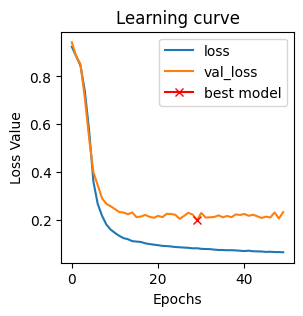

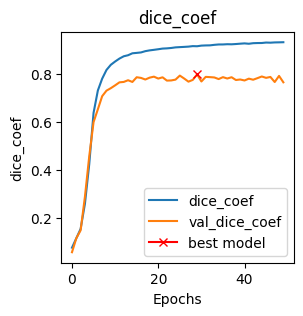

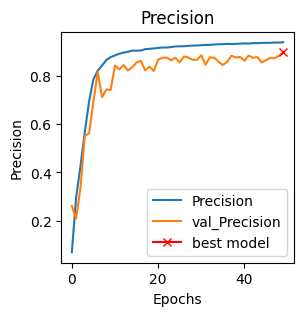

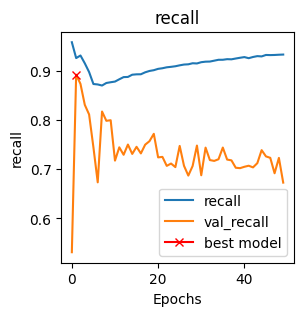

In [59]:
show_hist(model_histogram)